#1.Set up environment

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from sklearn import preprocessing
import pandas as pd
import scipy.signal
import pickle
import csv
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
import numpy as np, os, sys, joblib
import seaborn as sns
import tarfile

from scipy import optimize
from scipy.signal import butter, lfilter, filtfilt

from keras.utils import pad_sequences
import math

from tensorflow import keras

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model

import random
import sklearn
import keras.backend as K

from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

In [ ]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/corino/train

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1VNycZC_xFFpxCAqmRhHpLYkv_K4xtGLO/corino/train


#2.Importing segments and their corresponding labels

In [ ]:
save_directory = '/gdrive/MyDrive/corino/Processing_definitivo'
# Change the current working directory
os.chdir(save_directory)

# Load the data from the files
with open('segmenti_totali_check_28_01.txt', 'rb') as data_file:
    segmenti_totali = pickle.load(data_file)
with open('label_check_28_01.txt', 'rb') as data_file:
    label = pickle.load(data_file)

#3.Encoding labels

 Encoding the labels, setting N to 0 and V and S to 1, enabling binary classification

In [ ]:
label_modified = [
    np.where(arr == 'N', 0, arr) for arr in label
]

In [ ]:
label_modified1 = [
    np.where(arr == 'V', 1, arr) for arr in label_modified
]

In [ ]:
label_modified_final = [
    np.where(arr == 'S', 1, arr) for arr in label_modified1
]

# 4.Split between test,train and validation set
The split was done to maintain segmentations related to the same signal of a patient either in the train or in the test set, avoiding having segmentations of a signal in both the train and the test sets.

In [ ]:
prop_train = 0.75 # 70% for train
prop_test = 0.1  # 10% for test
prop_val = 0.15  # 15% for validation
tf.random.set_seed(seed)
# Perform the split
train_data, temp_data, train_label, temp_label = train_test_split(segmenti_totali, label_modified_final, test_size=1 - prop_train, random_state=seed)
test_data, val_data, test_label, val_label = train_test_split(temp_data, temp_label, test_size=prop_val / (prop_test + prop_val), random_state=seed)

Distribution of the number of patients across the various datasets

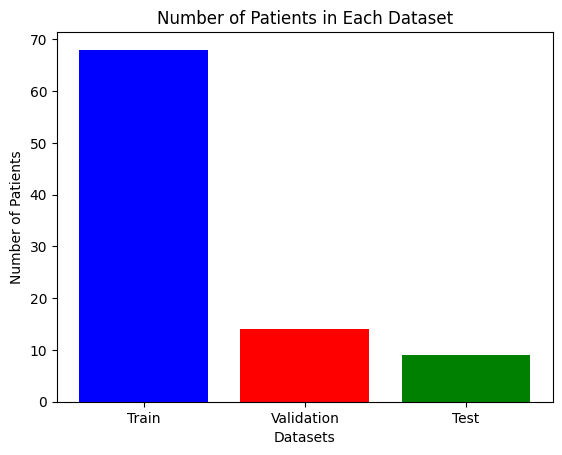

In [ ]:
# Data
sets = ['Train', 'Validation', 'Test']
counts = [len(train_label), len(val_label), len(test_label)]
colors = ['blue', 'red', 'green']

# Bar plot
plt.bar(sets, counts, color=colors)

# Adding labels
plt.xlabel('Datasets')
plt.ylabel('Number of Patients')
plt.title('Number of Patients in Each Dataset')

# Show the plot
plt.show()

Creation of a dataset by concatenating the various segments from different patients to provide the model with one segment at time, regardless of the patient

In [ ]:
train_seg=[]
for i in range (len(train_data)):
  train_seg.extend(train_data[i])

In [ ]:
test_seg=[]
for i in range (len(test_data)):
  test_seg.extend(test_data[i])

In [ ]:
val_seg=[]
for i in range (len(val_data)):
  val_seg.extend(val_data[i])

In [ ]:
label_train=[]
for i in range (len(train_label)):
  label_train.extend(train_label[i])

In [ ]:
label_test=[]
for i in range (len(test_label)):
  label_test.extend(test_label[i])

In [ ]:
label_validation=[]
for i in range (len(val_label)):
  label_validation.extend(val_label[i])

Distribution of the total segments in each dataset

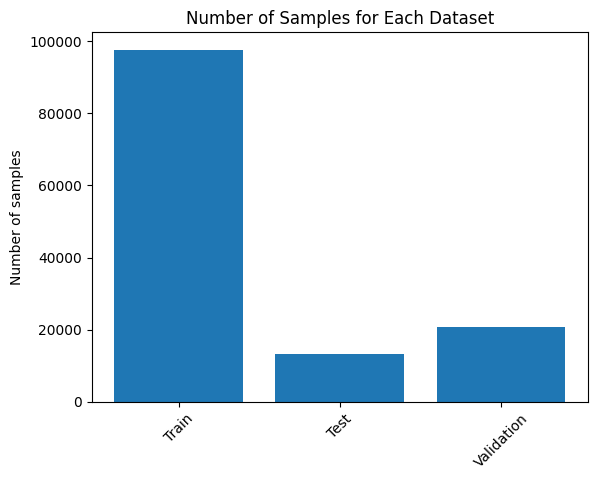

In [ ]:
datasets = ['Train', 'Test', 'Validation']
counts = [len(train_seg), len(test_seg), len(val_seg)]

plt.bar(datasets, counts)

plt.ylabel('Number of samples')
plt.title('Number of Samples for Each Dataset')
plt.xticks(rotation=45)

plt.show()

In [ ]:
print(len(train_seg),len(test_seg),len(val_seg),len(label_train),len(label_test),len(label_validation))

97684 13225 20826 97684 13225 20826


Class count for each set

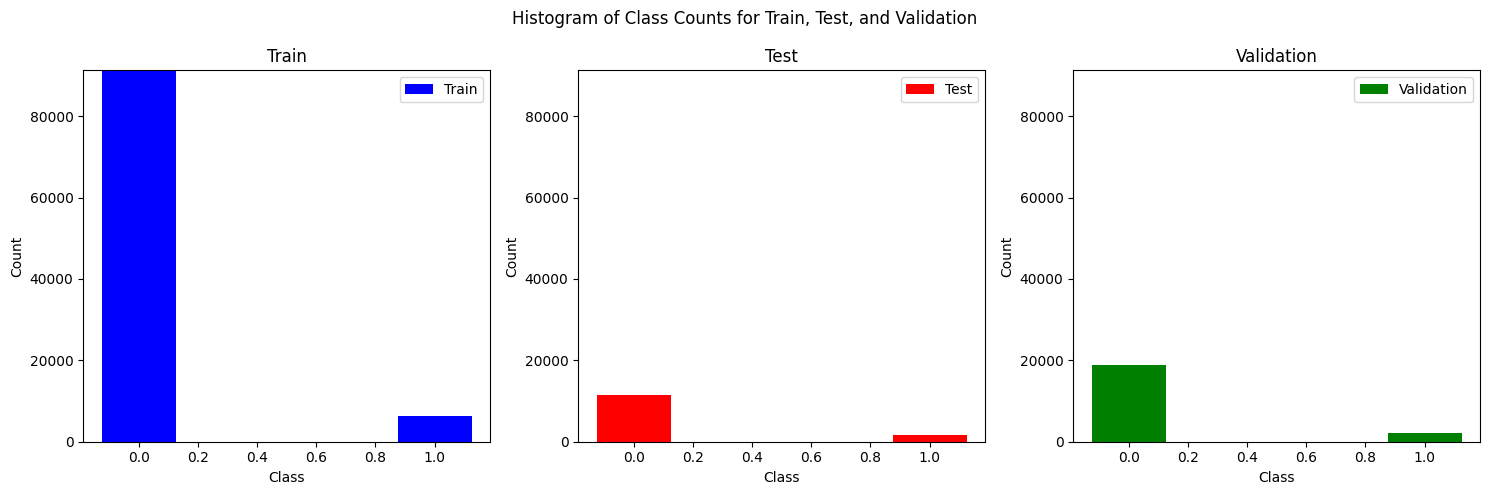

In [ ]:
# count the number of class for train,test and validation
counts_train = np.bincount(label_train)
counts_test = np.bincount(label_test)
counts_validation = np.bincount(label_validation)

classes = np.arange(len(counts_train))

max_count = max(max(counts_train), max(counts_test), max(counts_validation))

bar_width = 0.25

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

colors = ['blue', 'red', 'green']


for i, (counts, title, color) in enumerate(zip([counts_train, counts_test, counts_validation], ['Train', 'Test', 'Validation'], colors)):
    axs[i].bar(classes, counts, width=bar_width, label=title, color=color)
    axs[i].set_title(title)
    axs[i].set_ylim(0, max_count)

fig.suptitle('Histogram of Class Counts for Train, Test, and Validation')
for ax in axs:
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.legend()


plt.tight_layout()
plt.show()




# 5.Downsampling

Since the number of class N is much greater than the number of classes V + S, we have decided to apply downsampling of the majority class to achieve more balanced classes

We have decided to not use an equal number of samples for the first and second classes to avoid losing too many samples for model training. The ratio has been empirically determined based on the model's performance.

In [ ]:
#Count the number of samples for each class in the train set and the correspoding labels
label_train = np.array(label_train)
train_seg = np.array(train_seg)
label_train = label_train.astype(int)
count_class_0, count_class_1 = np.bincount(label_train)

# Define the desired ratio between classes
desired_ratio = 0.3

#Compute the target number of samples for the majority class
#We choose it based on the number of samples in the minority class
target_count_class_0 = int(count_class_1 * (1 / desired_ratio))

# save the indices of classes 0 and 1
class_0_indices = np.where(label_train == 0)[0]
class_1_indices = np.where(label_train == 1)[0]

# from the previous indices we select a number of samples for the majority class based on the chosen ratio between the two classes
#we randomly select the indices of class 0.
tf.random.set_seed(seed)
downsampled_class_0_indices = np.random.choice(class_0_indices, size=target_count_class_0, replace=False)

# Combine the indices of the minority and majority classes downsampled
#in order to create an array of indices to extract them in the initial training and label arrays
downsampled_indices = np.concatenate([downsampled_class_0_indices, class_1_indices])

# Creation of the new training set and corresponding labels
train_seg = train_seg[downsampled_indices]
label_train = label_train[downsampled_indices]


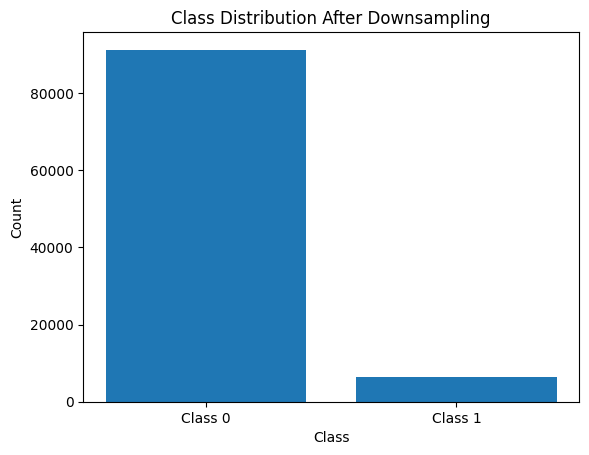

In [ ]:
# Creating class labels
classes = np.arange(2)

# Bar plot for class counts
plt.bar(classes, [count_class_0, count_class_1])

# Adding labels
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After Downsampling')

# Setting x-axis tick labels
plt.xticks(classes, ['Class 0', 'Class 1'])

# Showing the plot
plt.show()


#6.Padding

Since the segments are not of the same length, we applied padding. This is because when training a model, they require data of uniform size to be processed in batches. By adding padding to a sequence, it extends it to a specific length, and we used the length of the longest sequence in the training set for all datasets

In [ ]:
#Compute the maximum length among all segments
lunghezza_massima = max(len(seg) for seg in train_seg)

# Perform padding on all segments.
train_seg_padded = pad_sequences(train_seg, maxlen=lunghezza_massima, padding='post', truncating='post', dtype='float32')

#Now train_seg_padded contains the segments with padding


In [ ]:
# Perform padding on all segments of the validation set
val_seg_padded = pad_sequences(val_seg, maxlen=lunghezza_massima, padding='post', truncating='post', dtype='float32')

In [ ]:
# Perform padding on all segments of the test set
test_seg = pad_sequences(test_seg, maxlen=lunghezza_massima, padding='post', truncating='post', dtype='float32')

#7.Model training

As a model, we have created a composition of Convolutional Neural Network (CNN) layers and bidirectional LSTM layers. CNN layers are capable of recognizing local patterns within sequences of data, detecting patterns of local variations in signals.
Bidirectional LSTM layers, on the other hand, are useful for capturing long-term patterns in sequences of data. Bidirectionality means that the network runs both forward and backward on the input sequence, enabling it to capture both past and future information.
These two types of layers are combined to obtain a model that can capture both local and global information from sequential data. Additionally, dropout layers have been added to reduce overfitting

In [ ]:
cnn_model = keras.Sequential([
    layers.Conv1D(filters=16, kernel_size=3, padding='valid',
                  activation='relu', input_shape=(lunghezza_massima, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=16, kernel_size=3,
                  padding='same', activation='relu'),
    layers.Dropout(0.15),
    layers.Conv1D(filters=32, kernel_size=3,
                  padding='same', activation='relu'),
    layers.Dropout(0.15),
    layers.Conv1D(filters=64, kernel_size=3,
                  padding='same', activation='relu'),
    layers.Conv1D(filters=128, kernel_size=3,
                  padding='same', activation='relu'),
    layers.Conv1D(filters=256, kernel_size=3,
                  padding='same', activation='relu'),
    layers.Dropout(0.15),
    layers.Conv1D(filters=256, kernel_size=3,
                  padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dropout(0.3),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.3),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 208, 16)           64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 104, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 104, 16)           784       
                                                                 
 dropout (Dropout)           (None, 104, 16)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 104, 32)           1568      
                                                                 
 dropout_1 (Dropout)         (None, 104, 32)           0         
                                                        

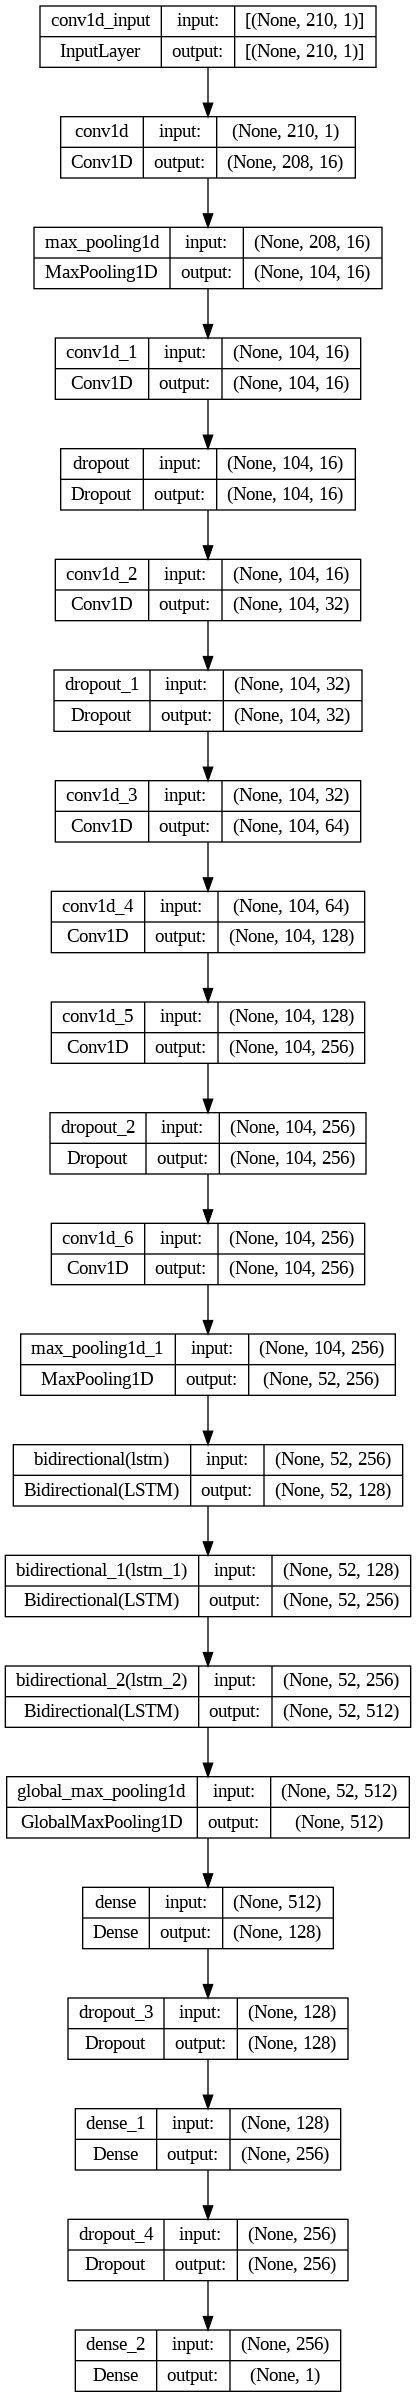

In [ ]:
#Plot of the model
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


it’s a regularisation technique  that helps prevent overfitting  by monitoring the validation loss. With a patience of 7 epochs, it allows  to interrupt the training process when the model's performance on the validation set stops to improve, thereby enhancing generalisation and avoiding unnecessary training epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", #monitor the validation loss
                                            min_delta=0.001, #improvement
                                            patience=7, #wait 7 epoch -> if there are no improvement stop
                                            verbose=0,
                                            mode = "auto",
                                            restore_best_weights=True,
                                            )

In [ ]:
learning_rate = 0.001

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss= 'binary_crossentropy',#We are using binary cross-entropy since we are in a binary classification task.
    metrics=[
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    ],#As evaluation metrics to monitor during model training, we have set recall and precision since the dataset is imbalanced, and accuracy is not reliable.
)

 transform the data into a format compatible with the model.

In [ ]:
train_seg_padded = np.array(train_seg_padded)
val_seg_padded = np.array(val_seg_padded)
test_seg = np.array(test_seg)

In [ ]:
x = np.expand_dims(train_seg_padded, axis=-1)
val = np.expand_dims(val_seg_padded, axis=-1)
test_seg = np.expand_dims(test_seg, axis=-1)

In [ ]:
x.shape

(27833, 210, 1)

In [ ]:
y = np.expand_dims(label_train, axis=-1)
y_val=np.expand_dims(label_validation, axis=-1)
label_test=np.expand_dims(label_test, axis=-1)

In [ ]:
y = np.array(y, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)
label_test = np.array(label_test, dtype=np.int32)


We have tried different batch sizes and epochs to find the best combination. In this file, only the one that returned the best performance has been reported

In [ ]:
history = cnn_model.fit(
    x = x,
    y = y,
    validation_data=(val, y_val),
    batch_size = 256,
    epochs = 20,
    callbacks=[callback]
).history

Epoch 1/20
109/109 [==============================] - 35s 134ms/step - loss: 0.3869 - precision: 0.6092 - recall: 0.4954 - val_loss: 0.4816 - val_precision: 0.2666 - val_recall: 0.9541
Epoch 2/20
109/109 [==============================] - 10s 96ms/step - loss: 0.3140 - precision: 0.7262 - recall: 0.6522 - val_loss: 0.3384 - val_precision: 0.4679 - val_recall: 0.7550
Epoch 3/20
109/109 [==============================] - 10s 92ms/step - loss: 0.2962 - precision: 0.7813 - recall: 0.6203 - val_loss: 0.3094 - val_precision: 0.5031 - val_recall: 0.5558
Epoch 4/20
109/109 [==============================] - 11s 99ms/step - loss: 0.2874 - precision: 0.7969 - recall: 0.6340 - val_loss: 0.2959 - val_precision: 0.5580 - val_recall: 0.7830
Epoch 5/20
109/109 [==============================] - 11s 105ms/step - loss: 0.2743 - precision: 0.8081 - recall: 0.6601 - val_loss: 0.2940 - val_precision: 0.5135 - val_recall: 0.7825
Epoch 6/20
109/109 [==============================] - 11s 100ms/step - loss: 0

# 8.Prediction

Use the model to make predictions on the test set

In [ ]:
y_pred_test = cnn_model.predict(test_seg)

414/414 [==============================] - 6s 9ms/step


Given that the activation function of the output layer is the sigmoid, which returns values between 0 and 1, it's necessary to establish a threshold to determine which class each prediction belongs to. Different threshold values have been tried to maximize our metrics, and in this code, the best one, 0.5, has been reported.

So in this case, if the predicted value is greater than 0.5, it is classified as the positive class (1), otherwise as the negative class (0).

This process is necessary to convert the predicted probabilities into binary predictions that can be used to evaluate the model's performance.

In [ ]:
y_pred_test_binary = (y_pred_test > 0.5).astype(int)

#Compute the confusion matrix
conf_matrix_test = confusion_matrix(label_test, y_pred_test_binary)

#Compute precision,recall,f1 of the test
precision_test = precision_score(label_test, y_pred_test_binary)
recall_test = recall_score(label_test, y_pred_test_binary)
f1_test = f1_score(label_test, y_pred_test_binary)

# Print the result
print("Test set - Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(precision_test, recall_test, f1_test))

Test set - Precision: 0.74, Recall: 0.84, F1 Score: 0.79


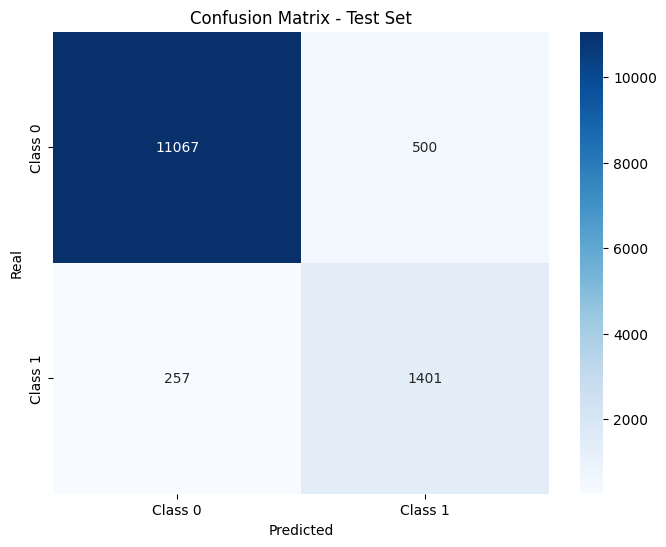

In [ ]:
# Plot the confusion matrix
def plot_confusion_matrix(conf_matrix, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(conf_matrix_test, classes=['Class 0', 'Class 1'], title='Confusion Matrix - Test Set')

In [ ]:
from sklearn.metrics import balanced_accuracy_score
bal_acc=balanced_accuracy_score(label_test,y_pred_test_binary)

In [ ]:
bal_acc

0.9008837743245077

#9.Confidence output sigmoid as our own metric

In [ ]:
count=0
somma_differenze=0
for i in range(len(y_pred_test_binary)):
  if y_pred_test_binary[i] == label_test[i]:
    somma_differenze += abs(0.5 - y_pred_test[i])
    count+=1
# Stampare il risultato
print("La somma delle differenze assolute tra 0.5 e ogni valore in y_pred è:", somma_differenze)

La somma delle differenze assolute tra 0.5 e ogni valore in y_pred è: [5238.484]


In [ ]:
confidence_giusti=somma_differenze/count

In [ ]:
confidence_giusti

array([0.42055908], dtype=float32)

In [ ]:
count=0
somma_differenze=0
for i in range(len(y_pred_test_binary)):
  if y_pred_test_binary[i] != label_test[i]:
    somma_differenze += abs(0.5 - y_pred_test[i])
    count+=1
# Stampare il risultato
print("La somma delle differenze assolute tra 0.5 e ogni valore in y_pred è:", somma_differenze)

La somma delle differenze assolute tra 0.5 e ogni valore in y_pred è: [174.85928]


In [ ]:
confidence_sbagliati=somma_differenze/count

In [ ]:
confidence_sbagliati

array([0.22738528], dtype=float32)